In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import re

import matplotlib

data_path = Path('hyperparam_results.csv')
assert data_path.exists()
df = pd.read_csv(data_path, index_col=0)

df.head()

,interface_type,epsilon,model_path,dataset_path,dim_mults,loss,lr,weight_decay,act_type,mean_dice,full_interface_name
0,InterfaceType.TANH_EPSILON,0.031250,../../output/lassen/interfacial_ae_v32_run_130...,/Users/murray/Projects/multphase_flow_encoder/...,"[1, 2, 4, 8, 8, 8]",mse,0.00100,0.000001,relu,0.165564,TANH (1/32)
1,InterfaceType.TANH_EPSILON,0.031250,../../output/lassen/interfacial_ae_v32_run_124...,/Users/murray/Projects/multphase_flow_encoder/...,"[1, 2, 4, 8, 8, 8]",l1,0.00001,0.000001,relu,0.624252,TANH (1/32)
2,InterfaceType.TANH_EPSILON,0.007812,../../output/lassen/interfacial_ae_v32_run_79_...,/Users/murray/Projects/multphase_flow_encoder/...,"[1, 2, 4, 8, 8, 8]",l1,0.00010,0.000100,relu,0.000000,TANH (1/128)
3,InterfaceType.TANH_EPSILON,0.125000,../../output/lassen/interfacial_ae_v32_run_164...,/Users/murray/Projects/multphase_flow_encoder/...,"[1, 2, 4, 8, 8, 8]",mse,0.00100,0.000100,tanh,0.137606,TANH (1/8)
4,InterfaceType.TANH_EPSILON,0.031250,../../output/lassen/interfacial_ae_v32_run_114...,/Users/murray/Projects/multphase_flow_encoder/...,"[1, 2, 4, 8, 8, 8]",l1,0.00010,0.000100,silu,0.000000,TANH (1/32)


Generating plot for interface: HEAVISIDE


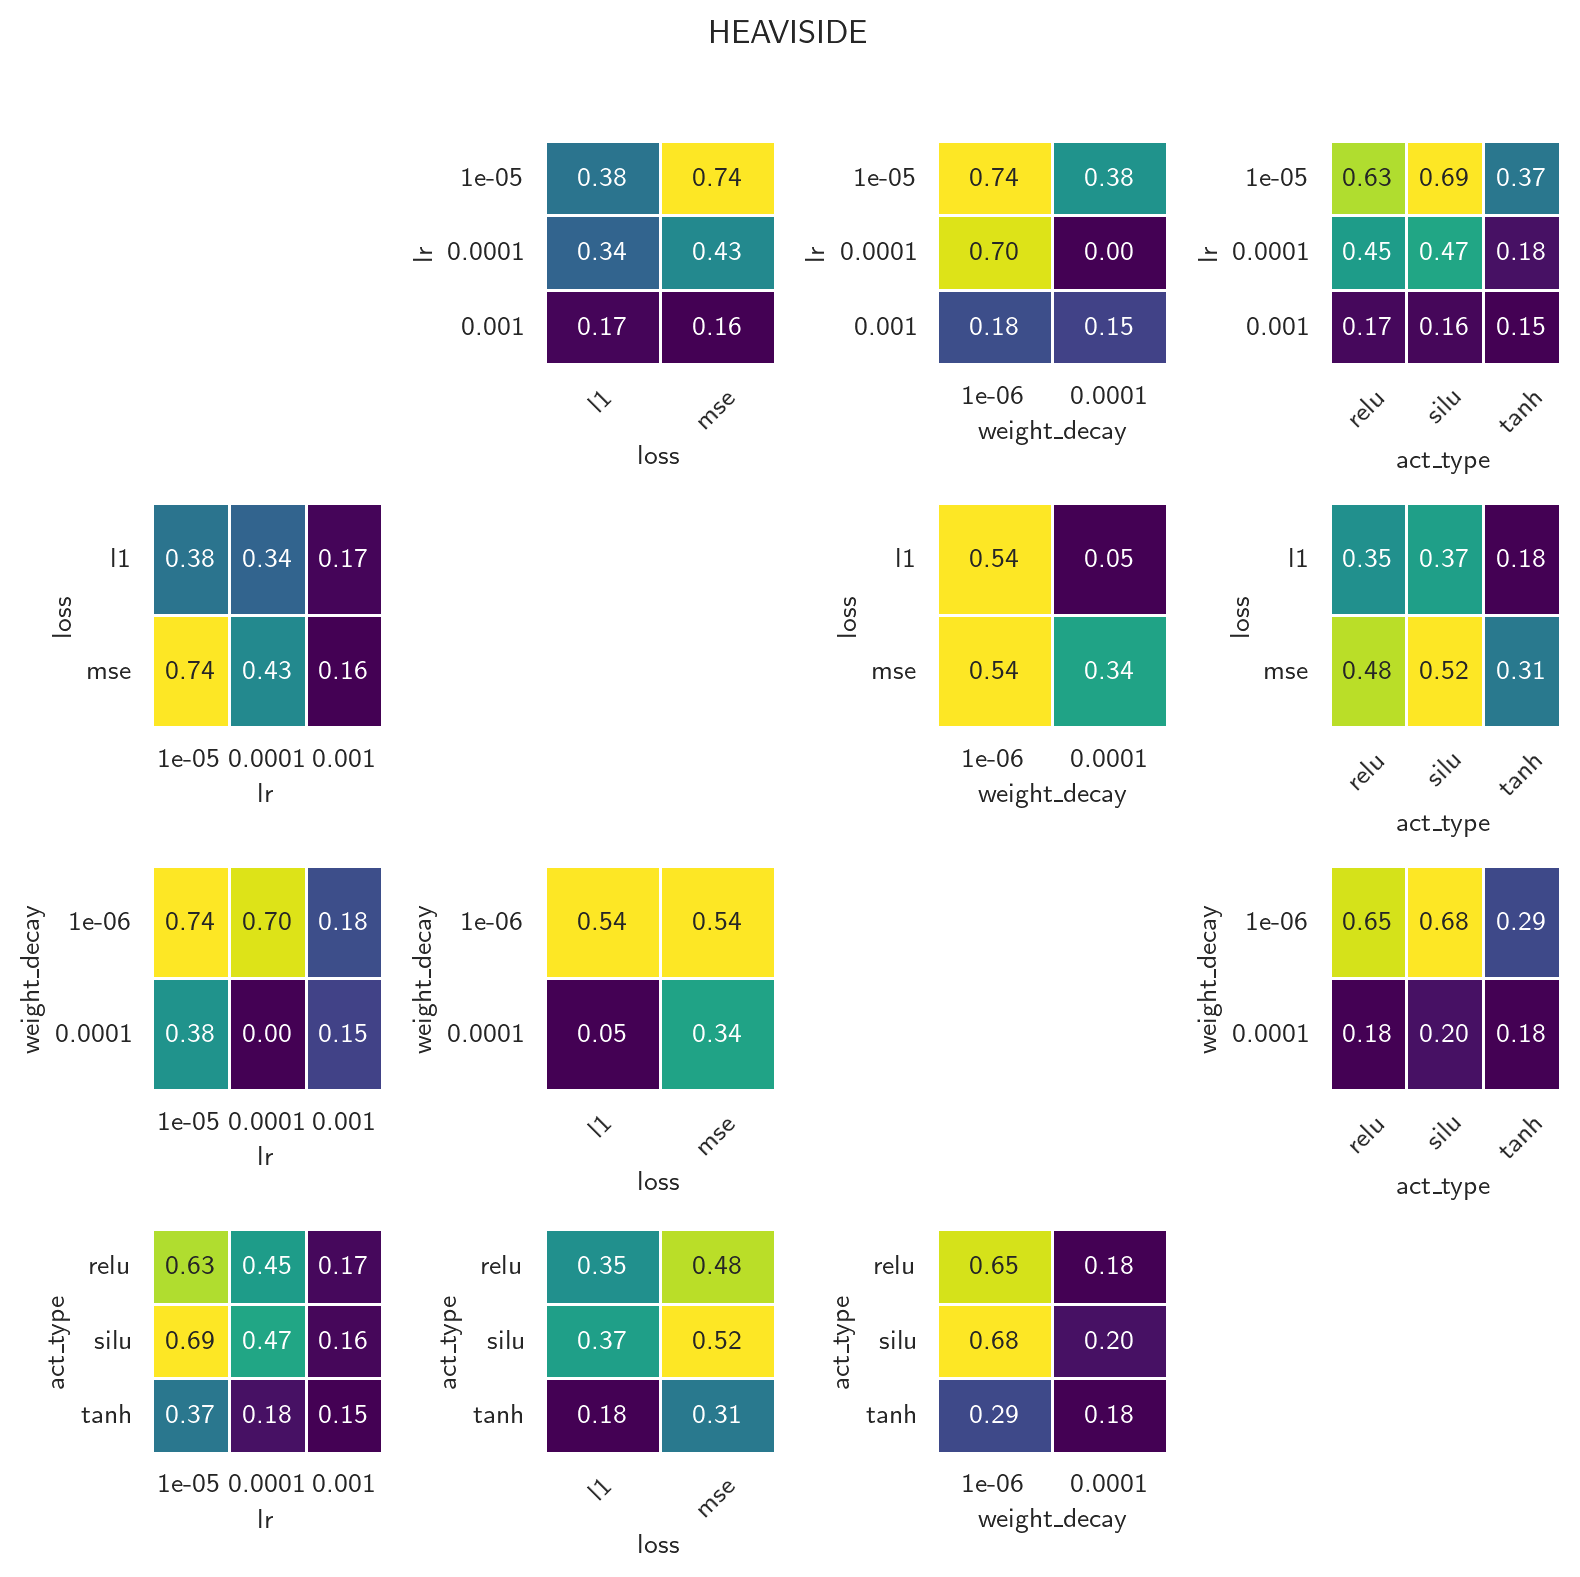

Generating plot for interface: SDF_EXACT


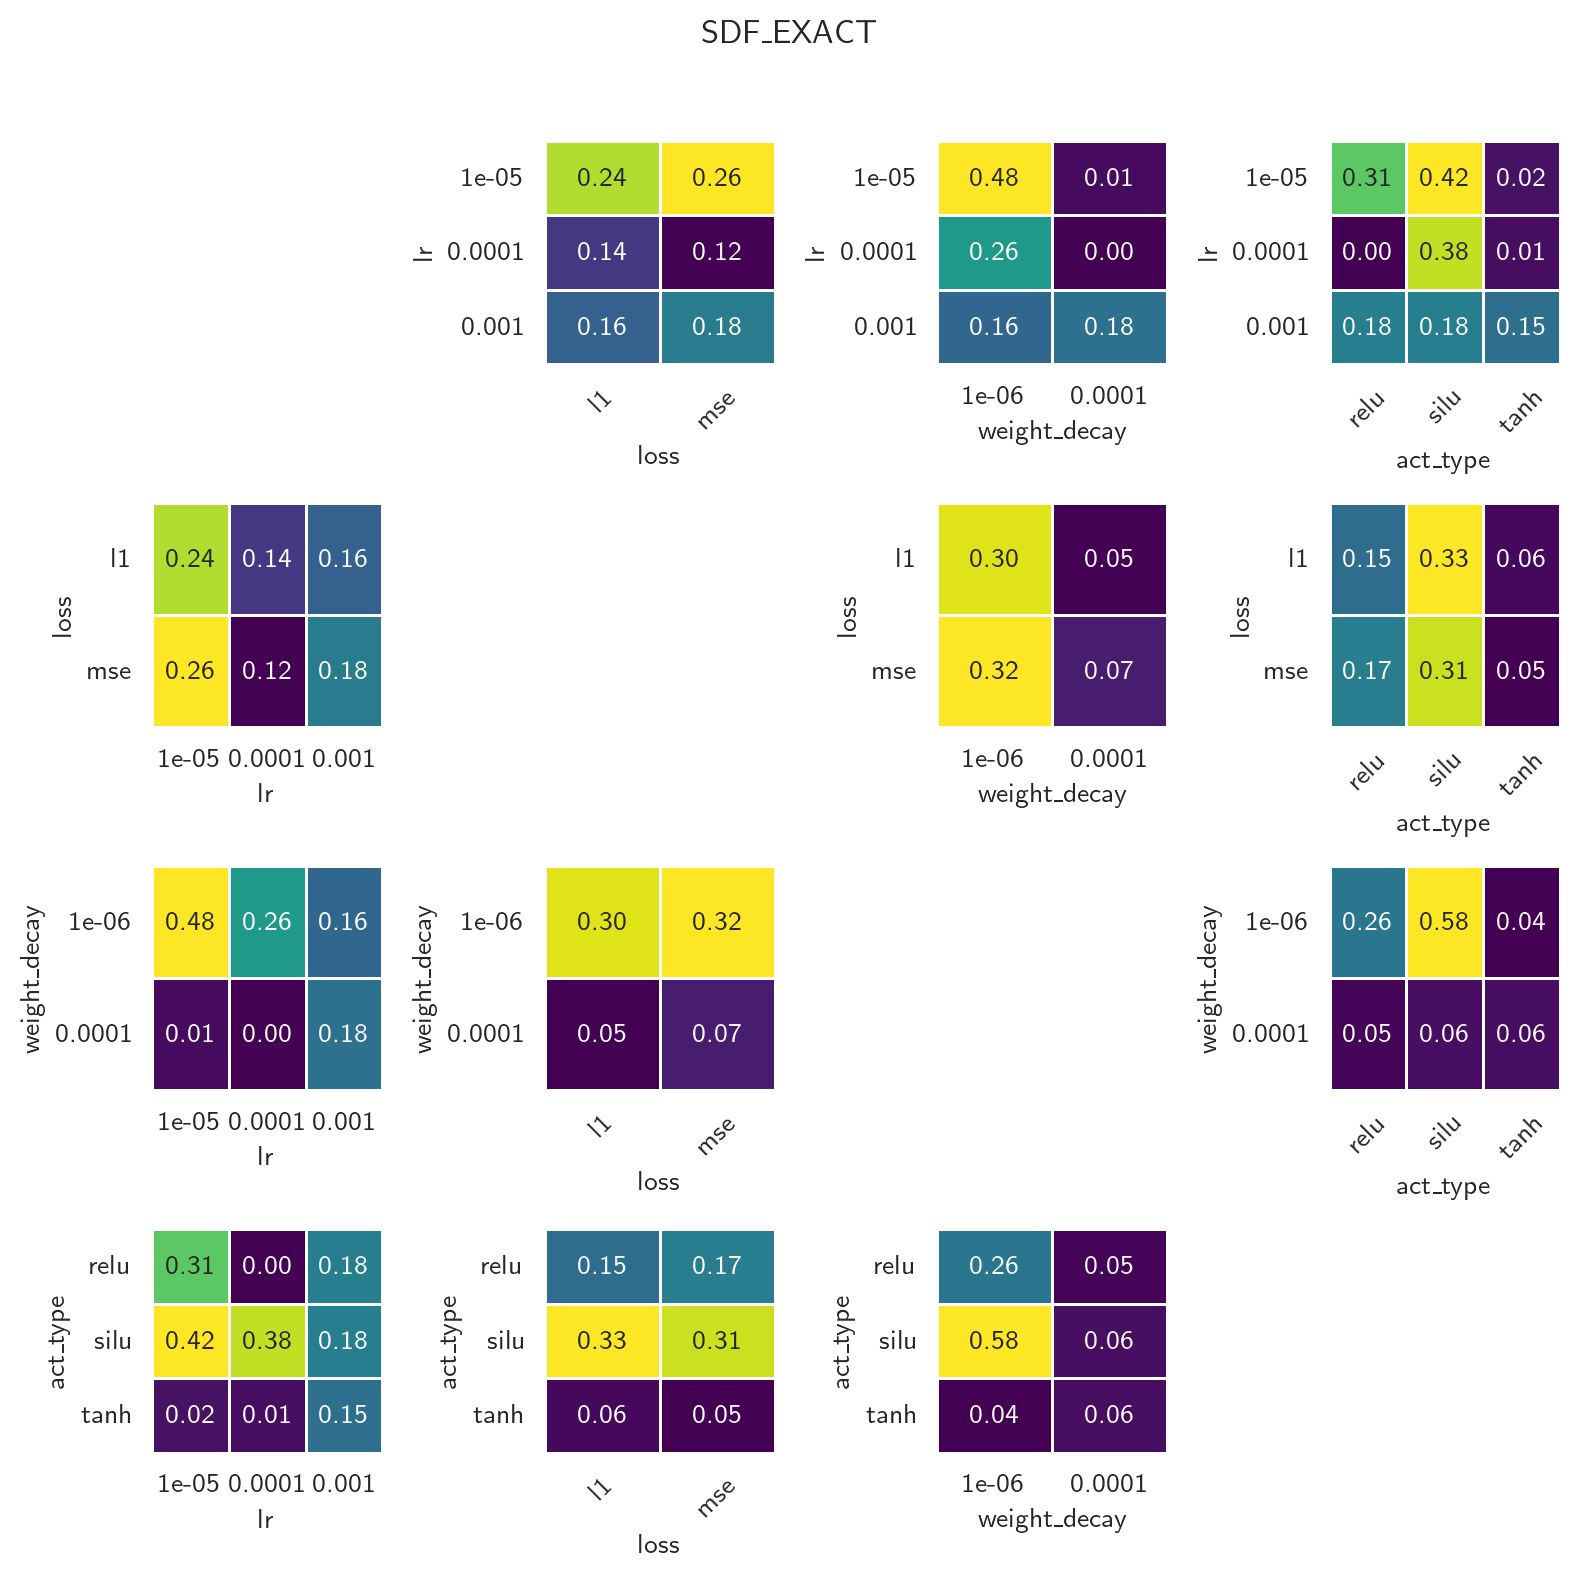

Generating plot for interface: TANH (1/128)


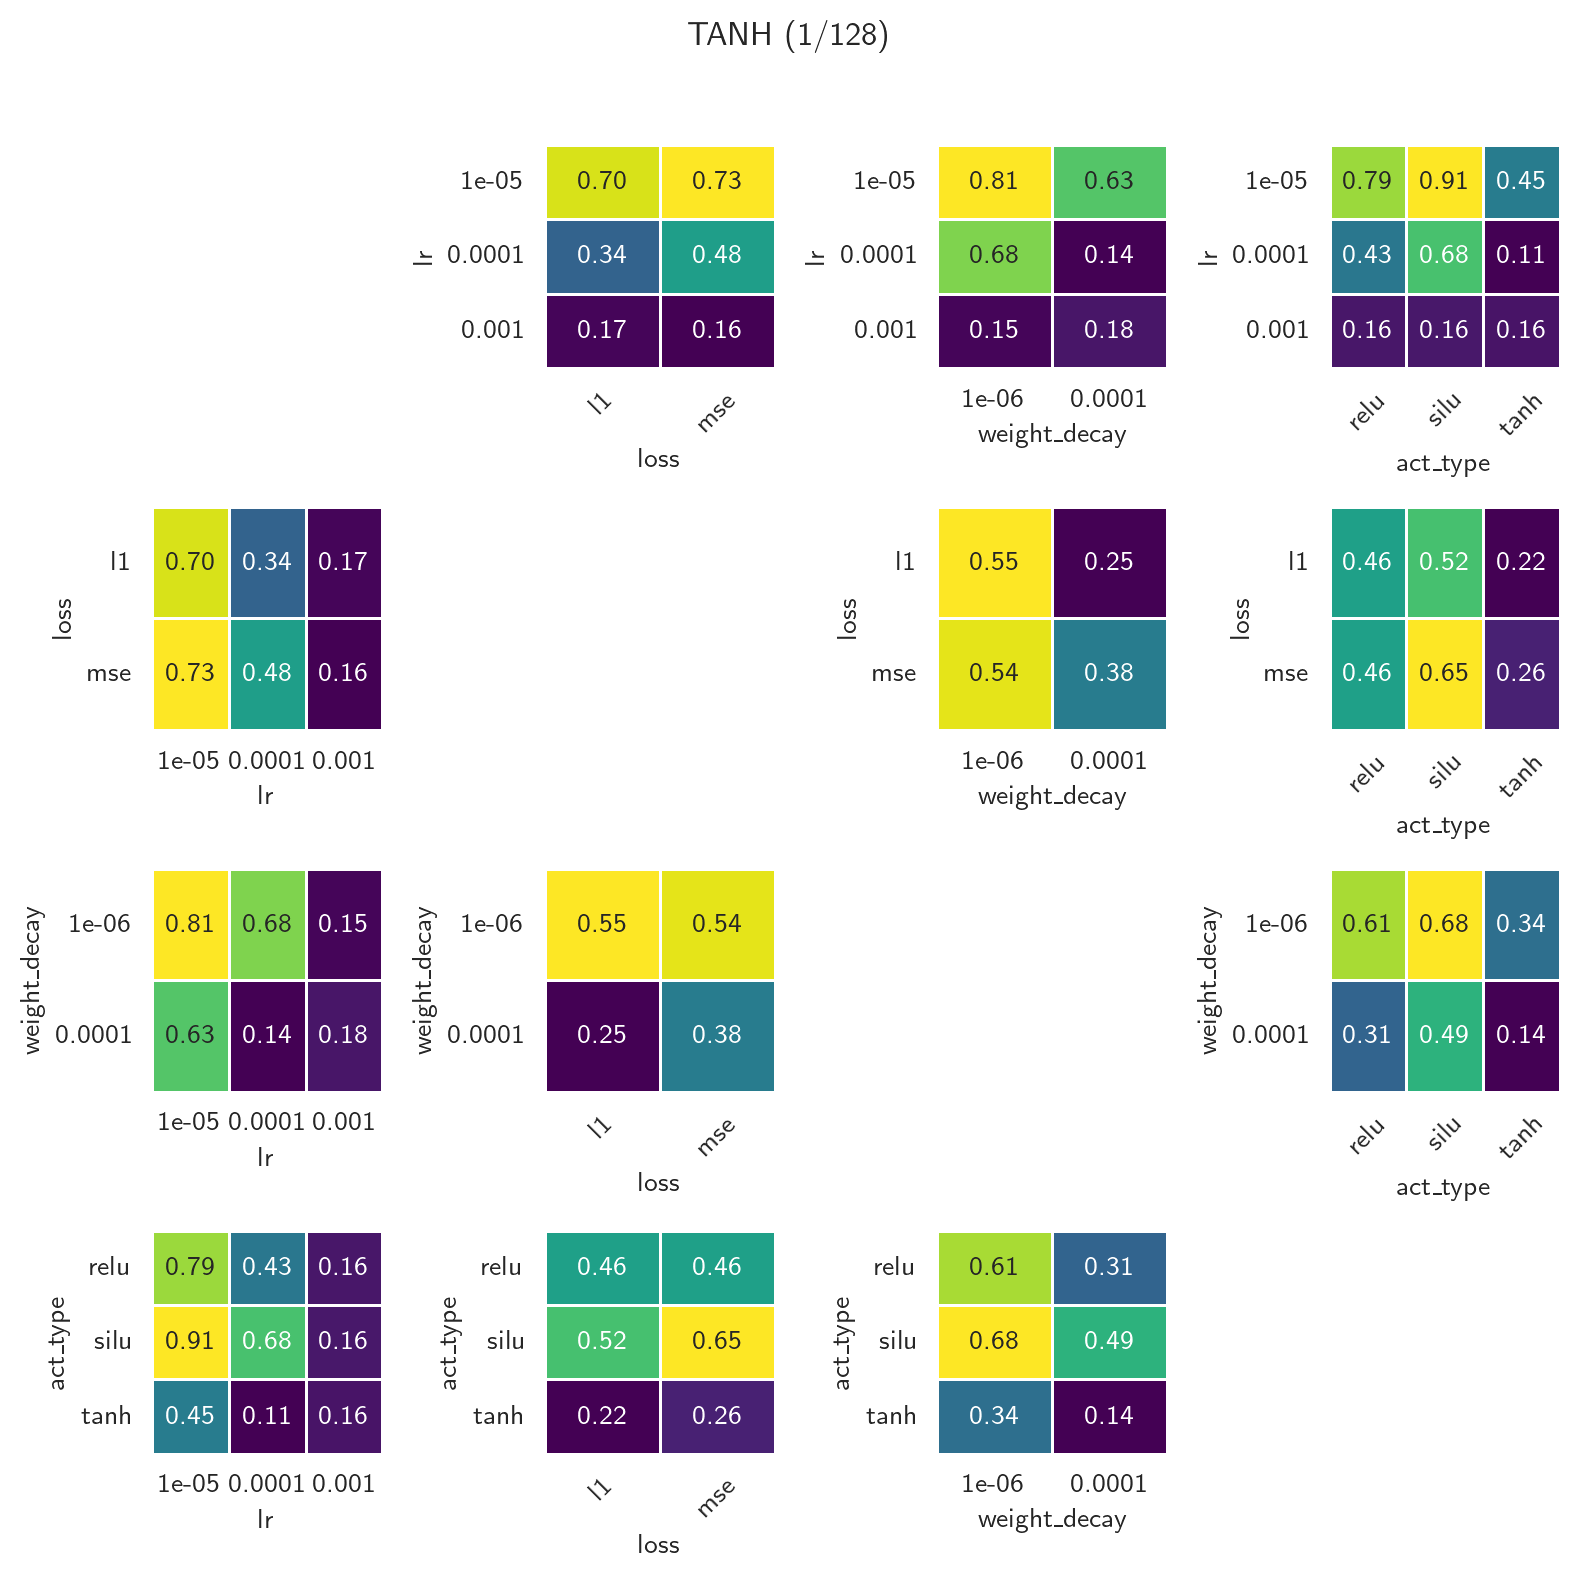

Generating plot for interface: TANH (1/32)


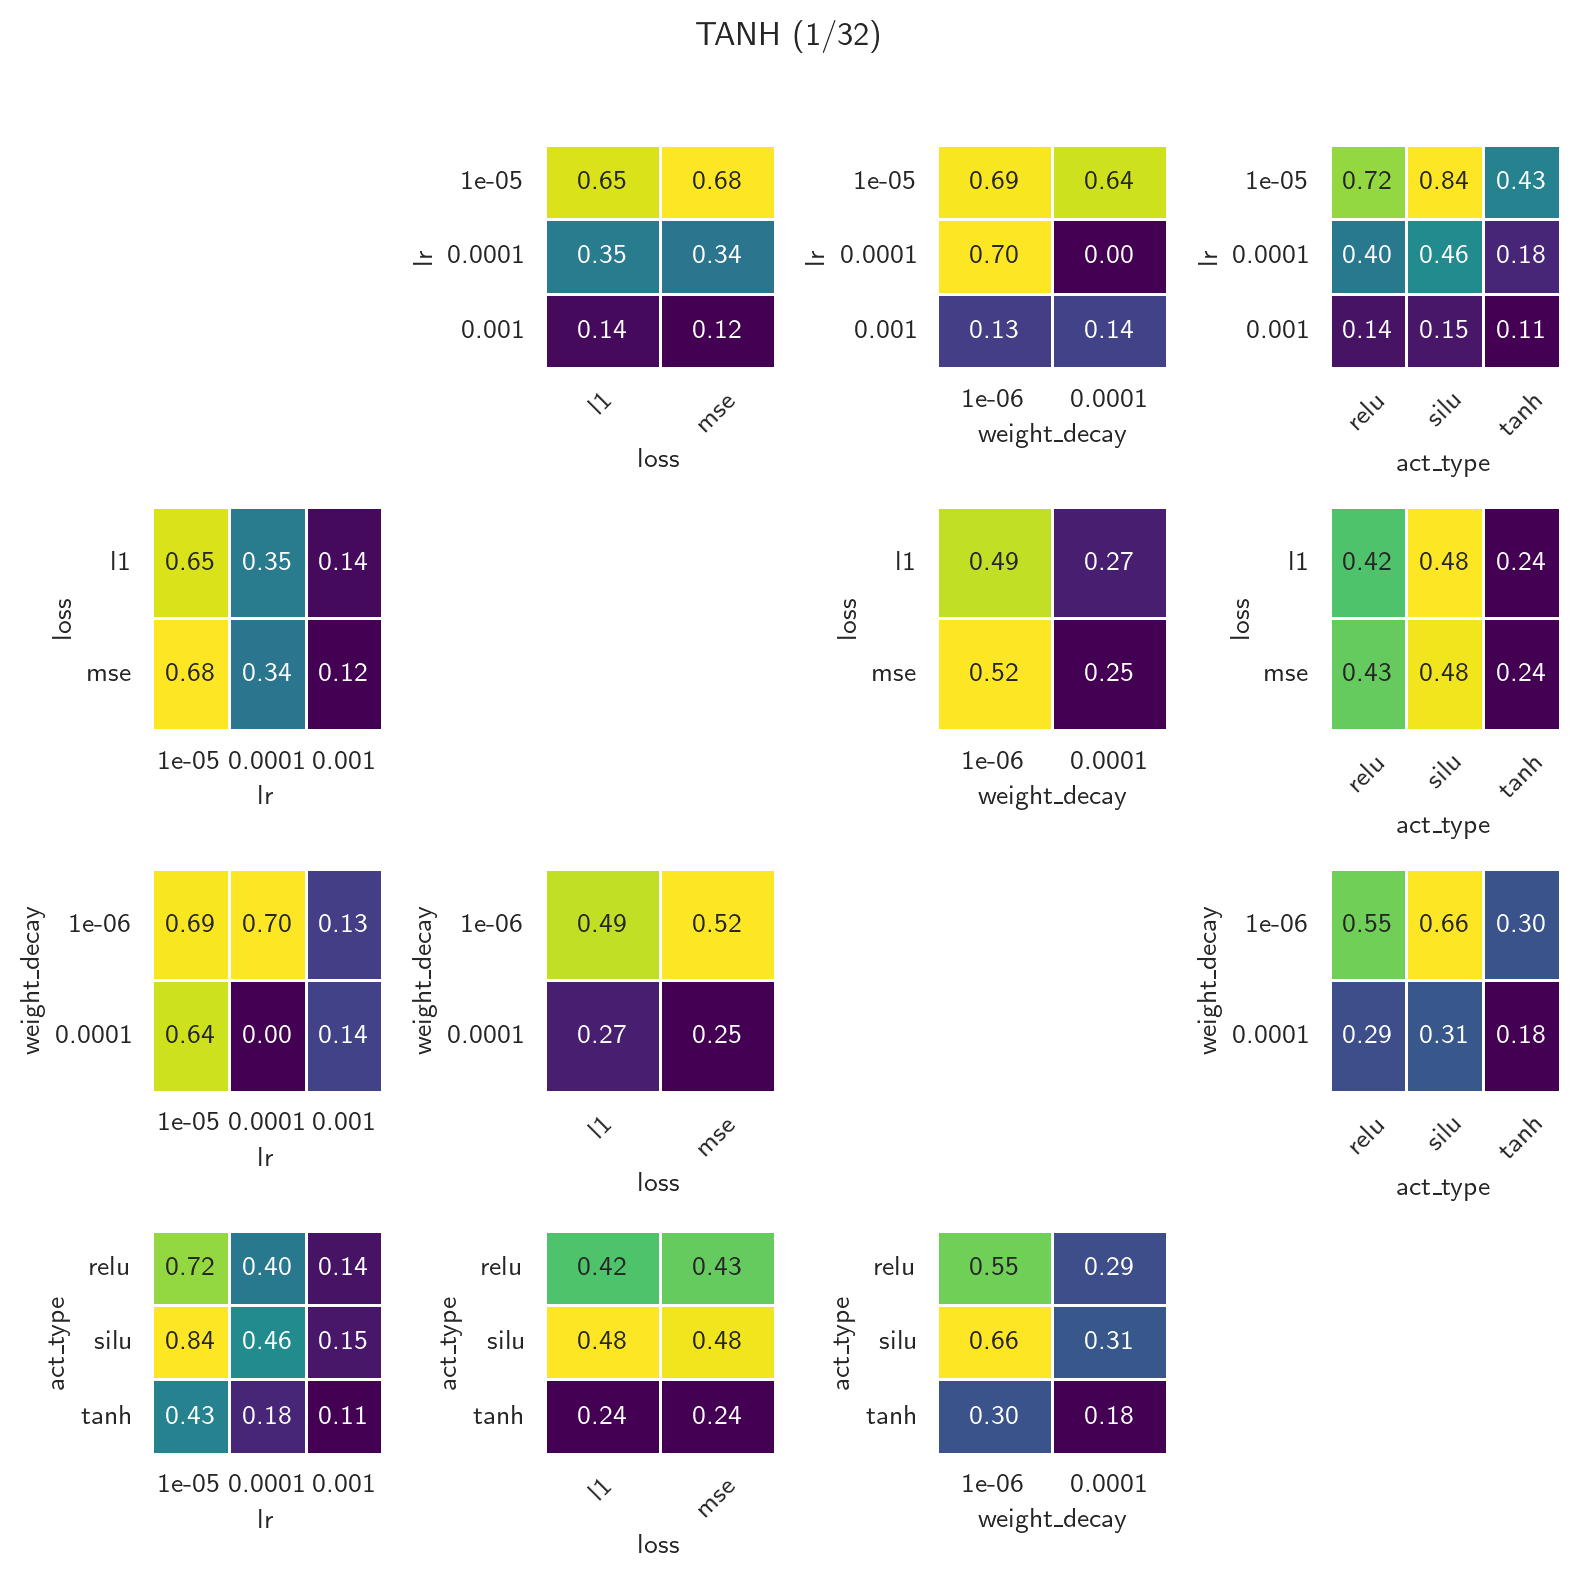

Generating plot for interface: TANH (1/8)


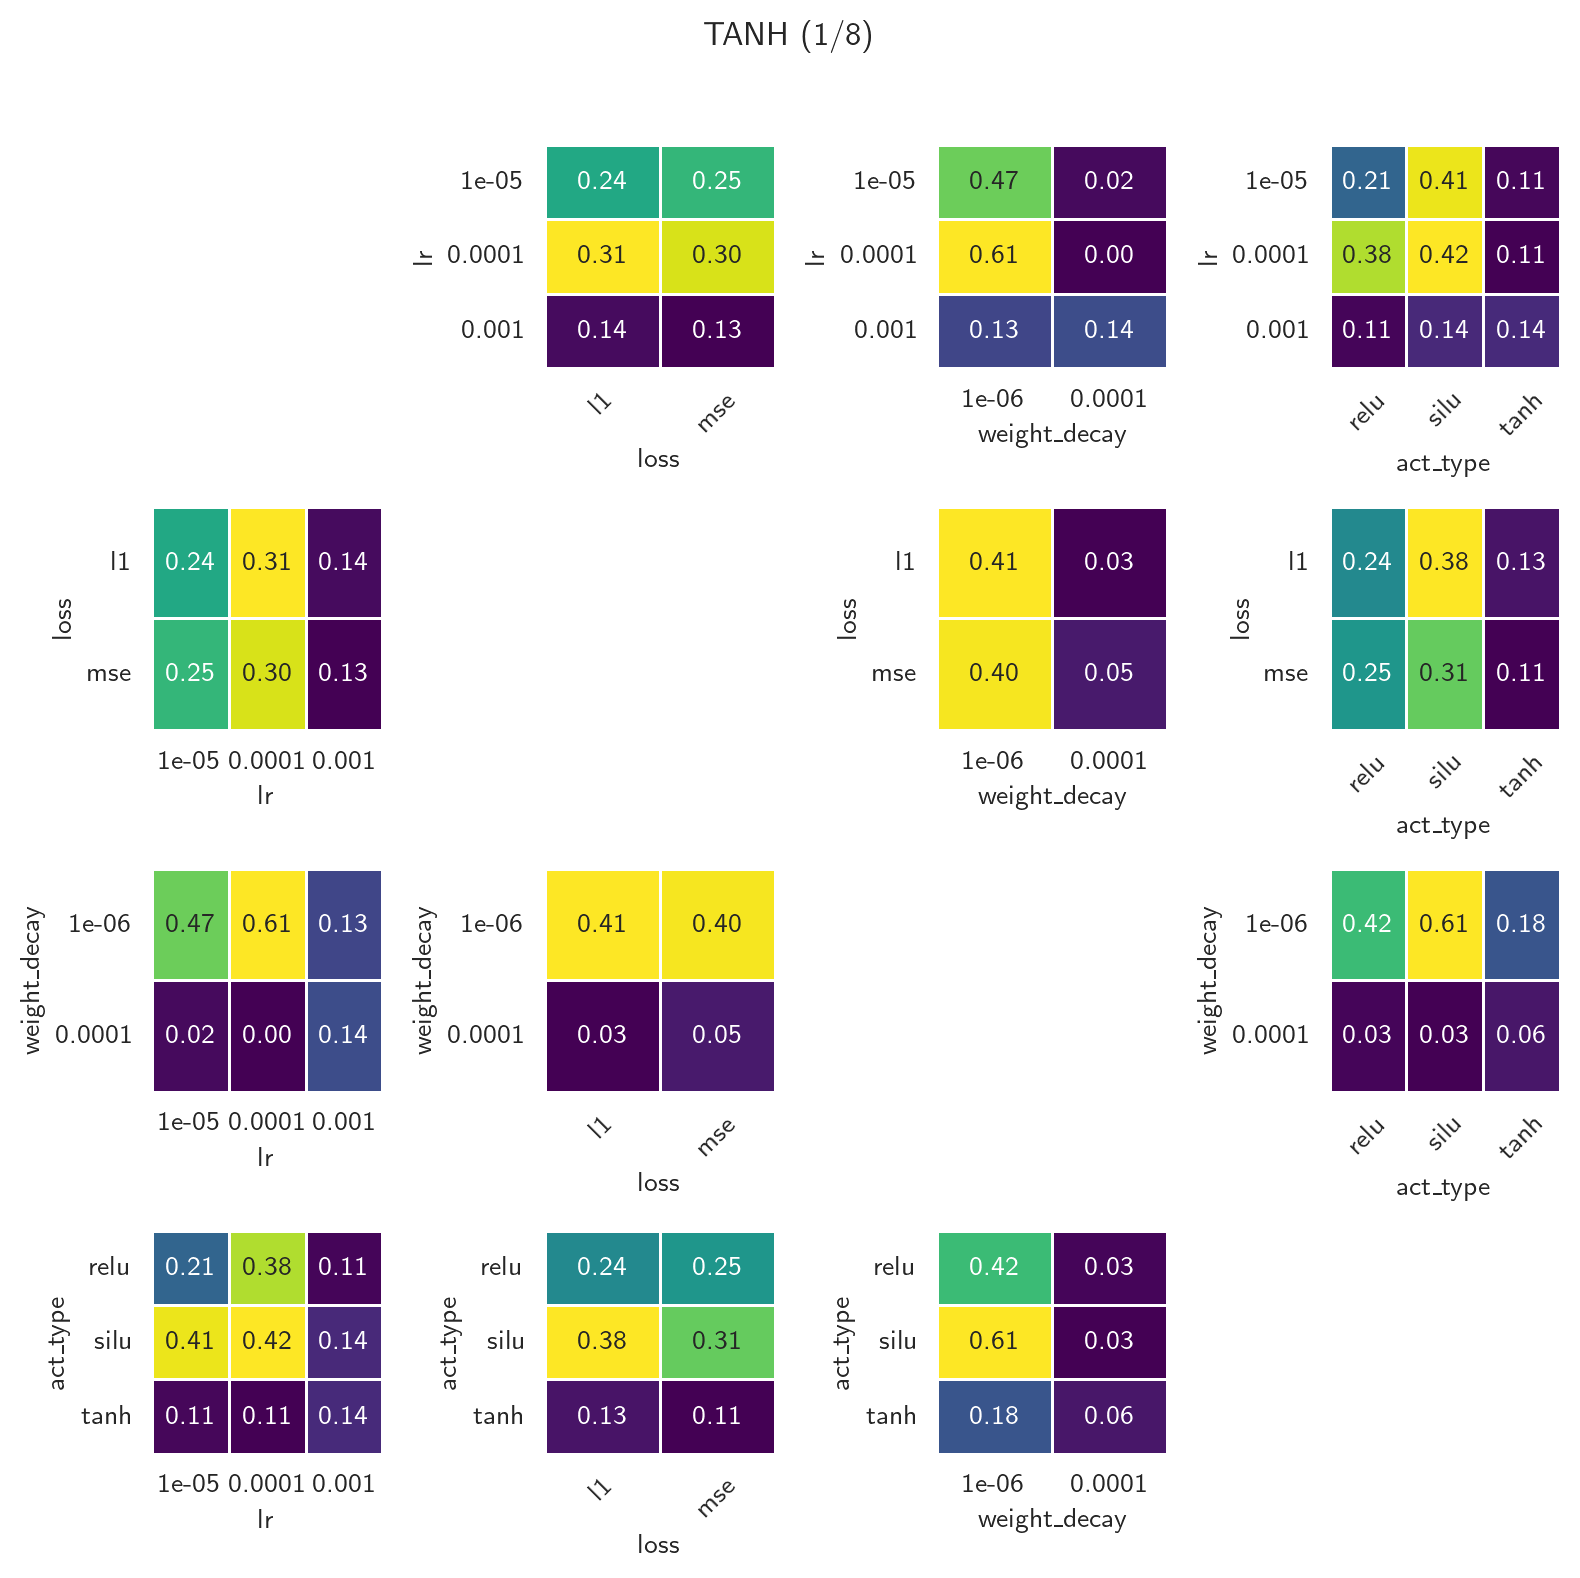

In [2]:
# --- Define the hyperparameters you want to create pairs from ---
hyperparams_to_plot = ['lr', 'loss', 'weight_decay', 'act_type']

# Get the unique, full interface names from your new column
# Sorting them ensures a consistent order of plots
all_interface_names = sorted(df['full_interface_name'].unique())

# --- Generate the plots for each unique interface configuration ---
for interface_name in all_interface_names:
    print('=' * 80)
    print(f"Generating plot for interface: {interface_name}")
    print('=' * 80)

    # Filter the DataFrame for the current interface configuration
    df_interface = df[df['full_interface_name'] == interface_name].copy()

    if df_interface.empty:
        print("No data found for this interface. Skipping plot.")
        continue

    # Create a grid of subplots for the pairplot
    n_params = len(hyperparams_to_plot)
    fig, axs = plt.subplots(n_params, n_params, figsize=(8, 8), dpi=200)
    fig.suptitle(f'{interface_name}', fontsize=12)

    # Iterate through each cell of the subplot grid
    for i, hp1 in enumerate(hyperparams_to_plot): # hp1 for rows
        for j, hp2 in enumerate(hyperparams_to_plot): # hp2 for columns
            ax = axs[i, j]

            # --- Diagonal Cells: Display hyperparameter name ---
            if i == j:
                ax.set_axis_off()
                continue
                ax.text(0.5, 0.5, hp1, ha='center', va='center', fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", fc="aliceblue", ec="black", lw=1))
                ax.set_xticks([])
                ax.set_yticks([])
                for spine in ax.spines.values():
                    spine.set_visible(False)
                continue

            # --- Off-Diagonal Cells: Create Heatmaps ---
            try:
                # Pivot the data to get Dice scores for each pair of hyperparameters
                pivot_df = df_interface.pivot_table(
                    index=hp1,
                    columns=hp2,
                    values='mean_dice',
                    aggfunc='mean'
                )

                # Sort for consistent axis ordering
                pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1)

                sns.heatmap(
                    pivot_df,
                    ax=ax,
                    annot=True,
                    fmt=".2f",
                    cmap='viridis',
                    linewidths=.5,
                    cbar=False
                )

                # Improve label readability
                if pivot_df.columns.dtype == 'object':
                    ax.tick_params(axis='x', rotation=45, labelsize=10)
                #if pivot_df.index.dtype == 'object':
                ax.tick_params(axis='y', rotation=0, labelsize=10)

            except Exception as e:
                ax.text(0.5, 0.5, 'Not enough data\nto create plot', ha='center', va='center', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                print(f"--> Could not generate plot for ({hp1}, {hp2}): {e}")

    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_70159/2124292310.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=best_scores.index, y=best_scores.values, palette='viridis')


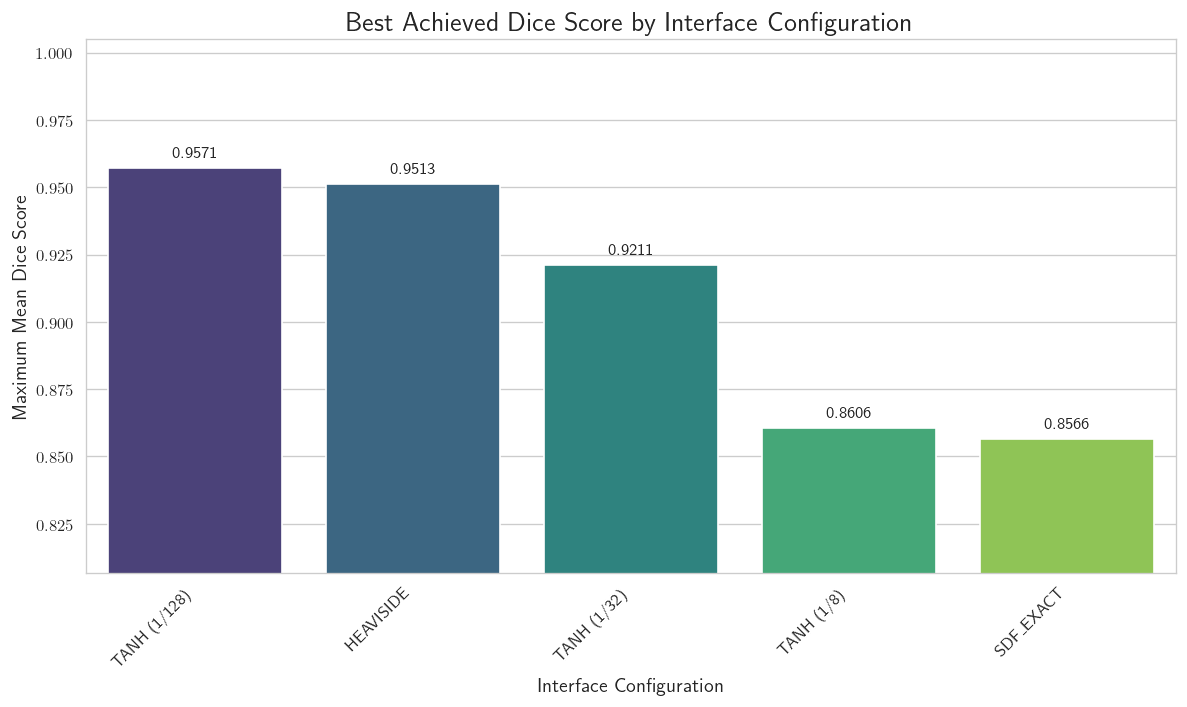

In [3]:

# --- Find the max Dice score for each interface ---
# Group by interface name and get the max, then sort
best_scores = df.groupby('full_interface_name')['mean_dice'].max().sort_values(ascending=False)

plt.figure(figsize=(10, 6), dpi=120)
ax = sns.barplot(x=best_scores.index, y=best_scores.values, palette='viridis')

plt.title('Best Achieved Dice Score by Interface Configuration', fontsize=16)
plt.xlabel('Interface Configuration', fontsize=12)
plt.ylabel('Maximum Mean Dice Score', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.ylim(bottom=max(0, best_scores.min() - 0.05)) # Adjust y-axis to focus on the top range

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

Attempting to reload custom Matplotlib defaults from: /Users/murray/.matplotlib/matplotlibrc
--- Generating Matplotlib Plot for: HEAVISIDE ---


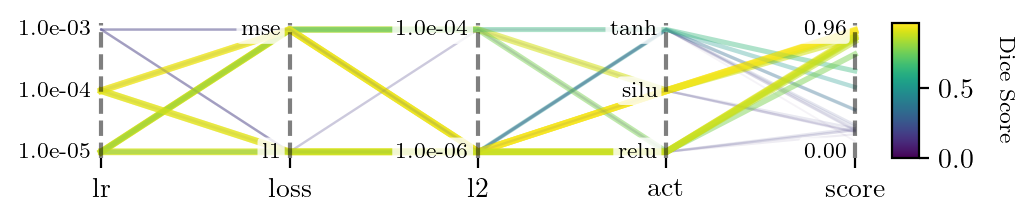

Successfully saved plot to: matplotlib_parallel_plots/mpl_pcoord_HEAVISIDE.pdf

--- Generating Matplotlib Plot for: SDF_EXACT ---


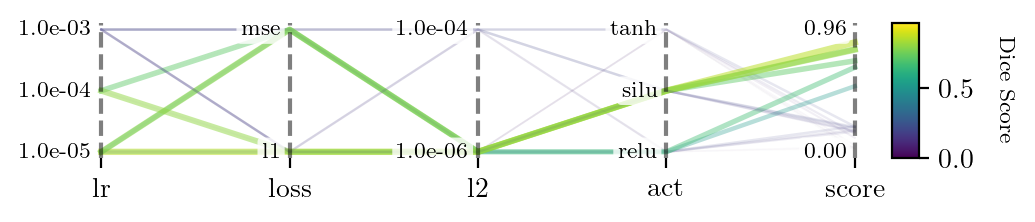

Successfully saved plot to: matplotlib_parallel_plots/mpl_pcoord_SDF_EXACT.pdf

--- Generating Matplotlib Plot for: TANH (1/128) ---


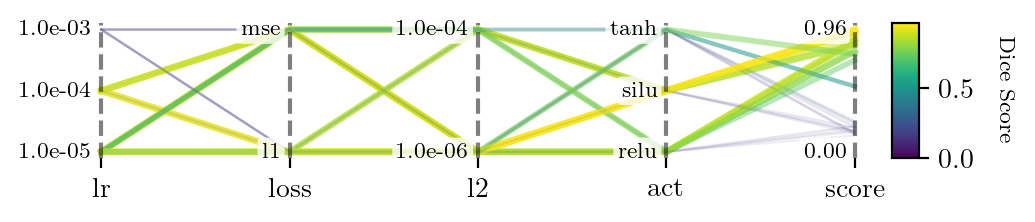

Successfully saved plot to: matplotlib_parallel_plots/mpl_pcoord_TANH__1_128_.pdf

--- Generating Matplotlib Plot for: TANH (1/32) ---


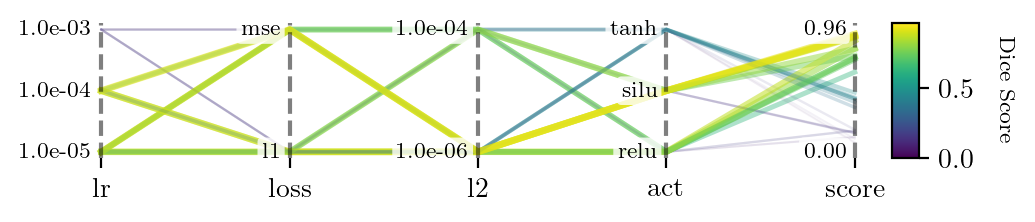

Successfully saved plot to: matplotlib_parallel_plots/mpl_pcoord_TANH__1_32_.pdf

--- Generating Matplotlib Plot for: TANH (1/8) ---


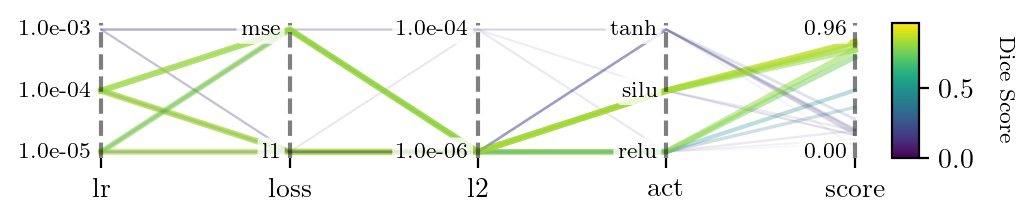

Successfully saved plot to: matplotlib_parallel_plots/mpl_pcoord_TANH__1_8_.pdf



In [4]:
rc_file_path = matplotlib.matplotlib_fname()
print(f"Attempting to reload custom Matplotlib defaults from: {rc_file_path}")
# Then, explicitly load it. This will apply your custom defaults.
matplotlib.rc_file(rc_file_path)

def normalize_columns(df, all_data_df):
    """
    Normalizes columns of a DataFrame to the [0, 1] range.
    Handles numerical, log-scale, and categorical data.
    Uses the full dataset (`all_data_df`) to determine global min/max for consistent scaling.
    """
    df_normalized = df.copy()
    y_ax_labels = {}

    for col in df.columns:
        # --- Handle Categorical Data ---
        if df[col].dtype == 'object':
            # Use the categories from the full dataset for consistency
            categories = sorted(all_data_df[col].unique())
            cat_map = {cat: i for i, cat in enumerate(categories)}

            # Normalize codes to be in [0, 1]
            num_cats = len(categories)
            df_normalized[col] = df[col].map(cat_map) / (num_cats - 1 if num_cats > 1 else 1)
            y_ax_labels[col] = categories

        # --- Handle Log-Scale Data ---
        elif col in ['lr', 'weight_decay']:
            # Replace 0 with a tiny number for log
            log_vals = np.log10(all_data_df[col].replace(0, 1e-9))
            min_log, max_log = log_vals.min(), log_vals.max()

            # Apply log and then min-max scale
            df_normalized[col] = (np.log10(df[col].replace(0, 1e-9)) - min_log) / (max_log - min_log + 1e-9)
            y_ax_labels[col] = [f"{10**min_log:.1e}", f"{10**max_log:.1e}"]

        # --- Handle Linear Numerical Data ---
        else:
            min_val, max_val = all_data_df[col].min(), all_data_df[col].max()
            df_normalized[col] = (df[col] - min_val) / (max_val - min_val + 1e-9)
            y_ax_labels[col] = [f"{min_val:.2f}", f"{max_val:.2f}"]

    return df_normalized, y_ax_labels


# --- Setup ---
output_dir = "matplotlib_parallel_plots"
os.makedirs(output_dir, exist_ok=True)

# Assume 'df' is your pre-existing DataFrame
all_interface_names = sorted(df['full_interface_name'].unique())
cols_to_plot = ['lr', 'loss', 'weight_decay', 'act_type', 'mean_dice']

label_map = {
    'lr': 'lr',
    'loss': 'loss',
    'weight_decay': 'l2',
    'act_type': 'act',
    'mean_dice': 'score'
}
short_labels = [label_map[col] for col in cols_to_plot]

# --- Set up colormap based on the full range of dice scores ---
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=df['mean_dice'].min(), vmax=df['mean_dice'].max())
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

lr_log_vals = np.log10(df['lr'].replace(0, 1e-9))
lr_min_log, lr_max_log = lr_log_vals.min(), lr_log_vals.max()

# --- NEW: Define properties for the text label background box ---
bbox_props = dict(
    boxstyle='round,pad=0.2',  # Rounded box with some padding
    facecolor='white',        # White background
    alpha=0.8,                # Semi-transparent
    edgecolor='none'          # No border on the box
)

min_alpha = 0.0
max_alpha = 0.6
min_width = 0.5
max_width = 2.5

# --- Main Loop ---
for interface_name in all_interface_names:
    print("=" * 70)
    print(f"--- Generating Matplotlib Plot for: {interface_name} ---")

    # 1. Filter data for the current interface
    df_interface = df[df['full_interface_name'] == interface_name]
    df_plot = df_interface[cols_to_plot].copy()

    if df_plot.shape[0] < 2:
        print("Skipping plot: Not enough data points.\n")
        continue

    # 2. Normalize the data using our helper function
    df_normalized, y_ax_labels = normalize_columns(df_plot, df[cols_to_plot])

    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(6, 1.2), dpi=200)

    # 4. Plot each row as a colored line
    for i in range(len(df_plot)):
        y_coords = df_normalized.iloc[i].values
        x_coords = np.arange(len(cols_to_plot))
        dice_score = df_plot.iloc[i]['mean_dice']

        # --- NEW: Calculate alpha based on the dice score ---
        # Normalize the score to the [0, 1] range using the global min/max
        normalized_dice = (dice_score - norm.vmin) / (norm.vmax - norm.vmin + 1e-9)
        # Map this normalized score to our desired alpha range
        variable_alpha = min_alpha + normalized_dice * (max_alpha - min_alpha)
        variable_width = min_width + normalized_dice * (max_width - min_width)

        # Plot the line with the calculated variable alpha
        ax.plot(x_coords, y_coords, color=scalar_mappable.to_rgba(dice_score), linewidth=variable_width, alpha=variable_alpha)



    ax.set_xticks(np.arange(len(cols_to_plot)))
    ax.set_xticklabels(short_labels, rotation=0) # <-- USE THE NEW LABELS
    ax.spines[:].set_visible(False)
    ax.grid(False)
    ax.yaxis.set_visible(False)

    # 6. Add custom parallel axes and labels
    for i, col in enumerate(cols_to_plot):
        # Draw the vertical axis line
        ax.axvline(x=i, color='black', alpha=0.5, linestyle='--')

        # Add labels for this axis
        labels = y_ax_labels[col]
        positions = np.linspace(0, 1, len(labels))
        for pos, label in zip(positions, labels):
             ax.text(i - 0.05, pos, label, ha='right', va='center', fontsize=8, bbox=bbox_props)

        # --- NEW: Add a special tick for the 'lr' column ---
        if col == 'lr':
            tick_val_to_add = 1e-4
            # Check if this tick is reasonably between the min and max to avoid clutter
            if 10**lr_min_log * 1.5 < tick_val_to_add < 10**lr_max_log / 1.5:
                # Calculate the normalized position of our new tick on the log scale
                log_tick_val = np.log10(tick_val_to_add)
                normalized_pos = (log_tick_val - lr_min_log) / (lr_max_log - lr_min_log + 1e-9)

                # Draw the new label
                ax.text(i - 0.05, normalized_pos, '1.0e-04', ha='right', va='center', fontsize=8, bbox=bbox_props)

    # 7. Add a colorbar
    cbar = fig.colorbar(scalar_mappable, ax=ax, pad=0.0, aspect=5)
    cbar.set_label('Dice Score', rotation=270, labelpad=15, fontsize=8)

    # 8. Set titles and save
    #ax.set_title(f"{interface_name}", pad=20)
    ax.set_ylim(-0.05, 1.05) # Add a little padding

    safe_filename = re.sub(r'[^\w\.\-]', '_', interface_name)
    pdf_path = os.path.join(output_dir, f"mpl_pcoord_{safe_filename}.pdf")

    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for colorbar
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.show()
    plt.close(fig) # IMPORTANT: Close figure in a loop to free memory

    print(f"Successfully saved plot to: {pdf_path}\n")

In [5]:
# Get the list of unique, sorted interface names to iterate over
all_interface_names = sorted(df['full_interface_name'].unique())

# --- Iterate through each interface type and display its top 5 runs ---

for interface_name in all_interface_names:
    # Print a clear header for each interface's section
    print("=" * 70)
    print(f"--- Top 5 Performing Hyperparameter Sets for: {interface_name} ---")
    print("=" * 70)

    # 1. Filter the DataFrame to get data only for the current interface
    df_interface = df[df['full_interface_name'] == interface_name]

    # 2. Sort this subset by dice score and get the top 5
    top_5_runs = df_interface.sort_values('mean_dice', ascending=False).head(5)

    if top_5_runs.empty:
        print("No runs found for this interface.\n")
        continue

    # 3. Select the columns to display in the table.
    # We can omit 'full_interface_name' as it's redundant under the header.
    cols_to_show = ['lr', 'loss', 'weight_decay', 'act_type', 'mean_dice']
    # Ensure all desired columns exist in the DataFrame to prevent errors
    cols_to_show = [col for col in cols_to_show if col in top_5_runs.columns]

    # 4. Apply styling to the resulting DataFrame for better visualization
    styled_df = top_5_runs[cols_to_show].style.background_gradient(
        cmap='viridis', # Use a reversed colormap so best scores are light
        subset=['mean_dice']
    ).format(
        {'mean_dice': "{:.5f}", 'lr': "{:.1e}", 'weight_decay': "{:.1e}"}
    ).set_caption(f"{interface_name}").hide(axis="index")

    # 5. Display the styled table
    display(styled_df)
    print("\n") # Add a newline for better spacing between tables


--- Top 5 Performing Hyperparameter Sets for: HEAVISIDE ---


lr,loss,weight_decay,act_type,mean_dice
1.0e-05,mse,1.0e-06,silu,0.95127
1.0e-04,mse,1.0e-06,silu,0.94681
1.0e-04,l1,1.0e-06,silu,0.94241
1.0e-05,l1,1.0e-06,silu,0.92306
1.0e-04,l1,1.0e-06,relu,0.90396




--- Top 5 Performing Hyperparameter Sets for: SDF_EXACT ---


lr,loss,weight_decay,act_type,mean_dice
1.0e-05,l1,1.0e-06,silu,0.85657
1.0e-05,mse,1.0e-06,silu,0.80358
1.0e-04,l1,1.0e-06,silu,0.79848
1.0e-04,mse,1.0e-06,silu,0.71195
1.0e-05,mse,1.0e-06,relu,0.66122




--- Top 5 Performing Hyperparameter Sets for: TANH (1/128) ---


lr,loss,weight_decay,act_type,mean_dice
1.0e-05,l1,1.0e-06,silu,0.95707
1.0e-04,mse,1.0e-06,silu,0.95048
1.0e-05,mse,1.0e-06,silu,0.94216
1.0e-04,l1,1.0e-06,silu,0.94054
1.0e-05,l1,1.0e-04,silu,0.90596




--- Top 5 Performing Hyperparameter Sets for: TANH (1/32) ---


lr,loss,weight_decay,act_type,mean_dice
1.0e-04,mse,1.0e-06,silu,0.92108
1.0e-05,mse,1.0e-06,silu,0.90967
1.0e-04,l1,1.0e-06,silu,0.90468
1.0e-05,l1,1.0e-06,silu,0.89881
1.0e-04,l1,1.0e-06,relu,0.87042




--- Top 5 Performing Hyperparameter Sets for: TANH (1/8) ---


lr,loss,weight_decay,act_type,mean_dice
1.0e-04,l1,1.0e-06,silu,0.86062
1.0e-05,l1,1.0e-06,silu,0.85612
1.0e-04,mse,1.0e-06,silu,0.82827
1.0e-05,mse,1.0e-06,silu,0.79815
1.0e-04,mse,1.0e-06,relu,0.79636


--- Generating plot to compare loss functions (Pure Matplotlib) ---
Custom x-axis order set to move 'SDF_EXACT' to the end.


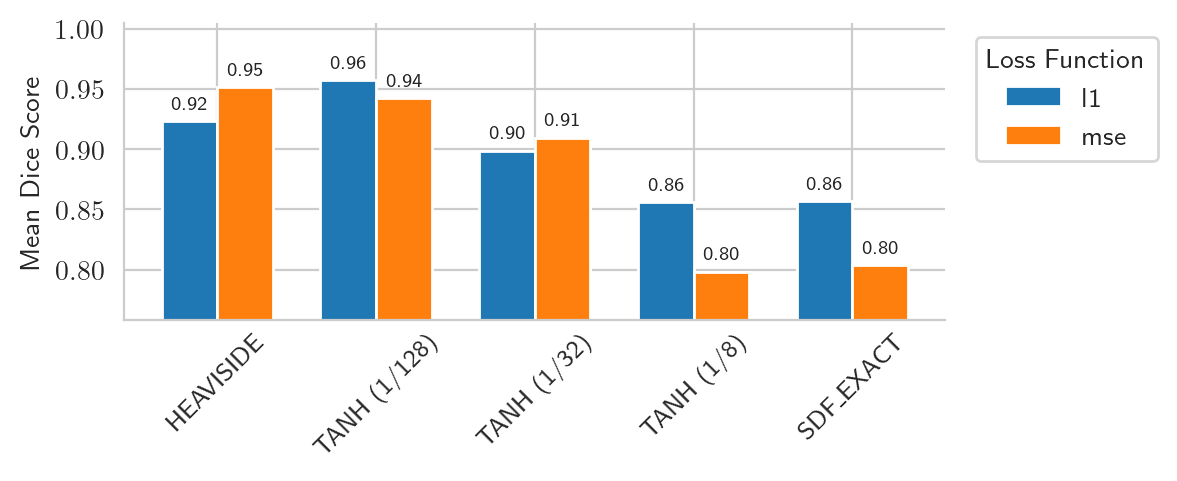

In [6]:
# ==============================================================================
# NEW PLOTTING CELL: Compare Loss Functions for a Fixed Hyperparameter Set (Pure Matplotlib)
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

print("=" * 80)
print("--- Generating plot to compare loss functions (Pure Matplotlib) ---")
print("=" * 80)

# --- Define the fixed hyperparameters for the comparison ---
FIXED_LR = 1e-5
FIXED_WEIGHT_DECAY = 1e-6
FIXED_ACT = 'silu'
INTERFACE_TO_MOVE_LAST = 'SDF_EXACT'

# --- Filter the DataFrame to get only the runs with these specific parameters ---
df_loss_comparison = df[
    (df['lr'] == FIXED_LR) &
    (df['weight_decay'] == FIXED_WEIGHT_DECAY) &
    (df['act_type'] == FIXED_ACT)
    ].copy()  # Use .copy() to avoid SettingWithCopyWarning

# --- Check if there is any data to plot after filtering ---
if df_loss_comparison.empty:
    print("\n!!! SKIPPING PLOT !!!")
    print("No data found for the specific hyperparameter combination:")
    print(f"  - Learning Rate (lr): {FIXED_LR}")
    print(f"  - Weight Decay (l2): {FIXED_WEIGHT_DECAY}")
    print(f"  - Activation (act): '{FIXED_ACT}'\n")
else:
    # --- 1. Prepare data and plot settings ---
    interface_order = sorted(df_loss_comparison['full_interface_name'].unique())
    if INTERFACE_TO_MOVE_LAST in interface_order:
        interface_order.remove(INTERFACE_TO_MOVE_LAST)
        interface_order.append(INTERFACE_TO_MOVE_LAST)
        print(f"Custom x-axis order set to move '{INTERFACE_TO_MOVE_LAST}' to the end.")

    # Get the two loss functions to compare, and sort for consistent color mapping
    loss_types = sorted(df_loss_comparison['loss'].unique())
    if len(loss_types) != 2:
        raise ValueError(f"Expected 2 loss types for comparison, but found {len(loss_types)}: {loss_types}")

    colors = ['C0', 'C1']
    bar_width = 0.35  # The width of a single bar

    # Main x-positions for each group (centered at 0, 1, 2, ...)
    x_positions = np.arange(len(interface_order))

    # --- 2. Create the plot and axes ---
    fig, ax = plt.subplots(figsize=(6, 2.5), dpi=200)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # --- 3. Loop through data and plot bars manually ---
    for i, interface_name in enumerate(interface_order):
        # Filter data for the current interface
        df_interface = df_loss_comparison[df_loss_comparison['full_interface_name'] == interface_name]

        # --- Plot the first bar (left bar of the pair) ---
        loss1_data = df_interface[df_interface['loss'] == loss_types[0]]
        score1 = loss1_data['mean_dice'].iloc[0] if not loss1_data.empty else 0
        pos1 = x_positions[i] - bar_width  # Position it to the left of the center
        ax.bar(pos1, score1, width=bar_width, color=colors[0], align='edge')

        # --- Plot the second bar (right bar of the pair) ---
        loss2_data = df_interface[df_interface['loss'] == loss_types[1]]
        score2 = loss2_data['mean_dice'].iloc[0] if not loss2_data.empty else 0
        pos2 = x_positions[i]  # Position it starting from the center
        ax.bar(pos2, score2, width=bar_width, color=colors[1], align='edge')

        # --- Add annotations ---
        if score1 > 0:
            ax.annotate(f'{score1:.2f}', (pos1 + bar_width / 2, score1), ha='center', va='bottom', fontsize=7,
                        xytext=(0, 3), textcoords='offset points')
        if score2 > 0:
            ax.annotate(f'{score2:.2f}', (pos2 + bar_width / 2, score2), ha='center', va='bottom', fontsize=7,
                        xytext=(0, 3), textcoords='offset points')

    # --- 4. Configure plot aesthetics ---

    # --- Titles and Labels ---
    title_str = (
        f'Loss Function Performance by Interface\n' f'(Fixed Params: lr={FIXED_LR}, l2={FIXED_WEIGHT_DECAY}, act={FIXED_ACT})')
    #ax.set_title(title_str, fontsize=14)
    ax.set_ylabel('Mean Dice Score', fontsize=10)
    #ax.set_xlabel('Interface Configuration', fontsize=10)

    # --- X-axis Ticks ---
    ax.set_xticks(x_positions)
    ax.set_xticklabels(interface_order, rotation=45, ha='center', fontsize=9)
    ax.tick_params(axis='x', length=0)  # Hide tick marks on x-axis

    # --- Y-axis Limit ---
    min_score = df_loss_comparison['mean_dice'].min()
    max_score = df_loss_comparison['mean_dice'].max()
    ax.set_ylim(bottom=max(0, min_score * 0.95), top=max_score * 1.05)

    # --- Legend ---
    legend_elements = [Patch(facecolor=colors[0], label=loss_types[0]),
                       Patch(facecolor=colors[1], label=loss_types[1])]
    ax.legend(handles=legend_elements, title='Loss Function', bbox_to_anchor=(1.02, 1), loc='upper left')

    # --- Final Layout ---
    plt.tight_layout()
    plt.show()

--- Generating plot to compare loss functions (Pure Matplotlib) ---
Custom x-axis order set to move 'SDF_EXACT' to the end.


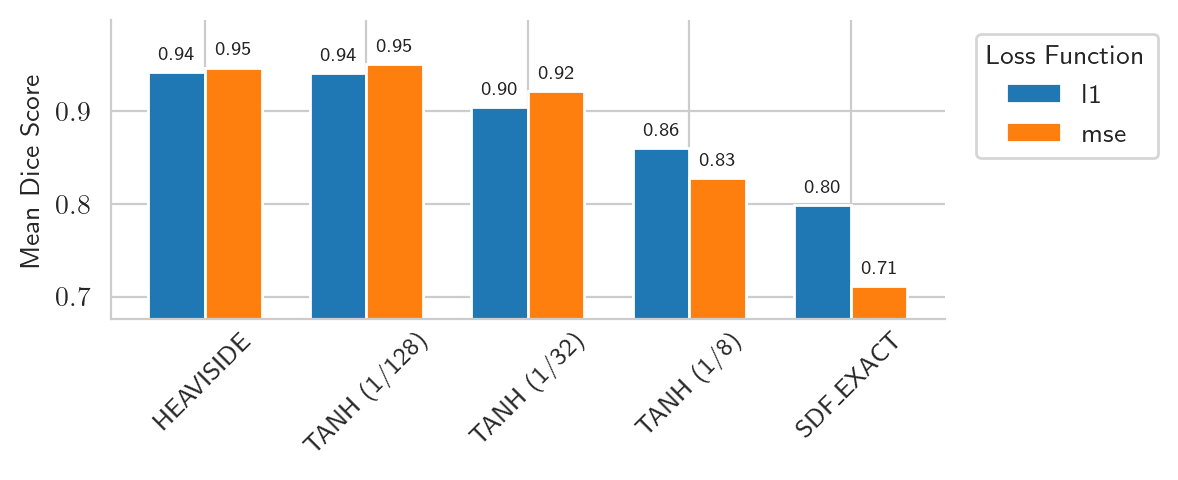

In [7]:
# ==============================================================================
# NEW PLOTTING CELL: Compare Loss Functions for a Fixed Hyperparameter Set (Pure Matplotlib)
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

print("=" * 80)
print("--- Generating plot to compare loss functions (Pure Matplotlib) ---")
print("=" * 80)

# --- Define the fixed hyperparameters for the comparison ---
FIXED_LR = 1e-4
FIXED_WEIGHT_DECAY = 1e-6
FIXED_ACT = 'silu'
INTERFACE_TO_MOVE_LAST = 'SDF_EXACT'

# --- Filter the DataFrame to get only the runs with these specific parameters ---
df_loss_comparison = df[
    (df['lr'] == FIXED_LR) &
    (df['weight_decay'] == FIXED_WEIGHT_DECAY) &
    (df['act_type'] == FIXED_ACT)
    ].copy()  # Use .copy() to avoid SettingWithCopyWarning

# --- Check if there is any data to plot after filtering ---
if df_loss_comparison.empty:
    print("\n!!! SKIPPING PLOT !!!")
    print("No data found for the specific hyperparameter combination:")
    print(f"  - Learning Rate (lr): {FIXED_LR}")
    print(f"  - Weight Decay (l2): {FIXED_WEIGHT_DECAY}")
    print(f"  - Activation (act): '{FIXED_ACT}'\n")
else:
    # --- 1. Prepare data and plot settings ---
    interface_order = sorted(df_loss_comparison['full_interface_name'].unique())
    if INTERFACE_TO_MOVE_LAST in interface_order:
        interface_order.remove(INTERFACE_TO_MOVE_LAST)
        interface_order.append(INTERFACE_TO_MOVE_LAST)
        print(f"Custom x-axis order set to move '{INTERFACE_TO_MOVE_LAST}' to the end.")

    # Get the two loss functions to compare, and sort for consistent color mapping
    loss_types = sorted(df_loss_comparison['loss'].unique())
    if len(loss_types) != 2:
        raise ValueError(f"Expected 2 loss types for comparison, but found {len(loss_types)}: {loss_types}")

    colors = ['C0', 'C1']
    bar_width = 0.35  # The width of a single bar

    # Main x-positions for each group (centered at 0, 1, 2, ...)
    x_positions = np.arange(len(interface_order))

    # --- 2. Create the plot and axes ---
    fig, ax = plt.subplots(figsize=(6, 2.5), dpi=200)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # --- 3. Loop through data and plot bars manually ---
    for i, interface_name in enumerate(interface_order):
        # Filter data for the current interface
        df_interface = df_loss_comparison[df_loss_comparison['full_interface_name'] == interface_name]

        # --- Plot the first bar (left bar of the pair) ---
        loss1_data = df_interface[df_interface['loss'] == loss_types[0]]
        score1 = loss1_data['mean_dice'].iloc[0] if not loss1_data.empty else 0
        pos1 = x_positions[i] - bar_width  # Position it to the left of the center
        ax.bar(pos1, score1, width=bar_width, color=colors[0], align='edge')

        # --- Plot the second bar (right bar of the pair) ---
        loss2_data = df_interface[df_interface['loss'] == loss_types[1]]
        score2 = loss2_data['mean_dice'].iloc[0] if not loss2_data.empty else 0
        pos2 = x_positions[i]  # Position it starting from the center
        ax.bar(pos2, score2, width=bar_width, color=colors[1], align='edge')

        # --- Add annotations ---
        if score1 > 0:
            ax.annotate(f'{score1:.2f}', (pos1 + bar_width / 2, score1), ha='center', va='bottom', fontsize=7,
                        xytext=(0, 3), textcoords='offset points')
        if score2 > 0:
            ax.annotate(f'{score2:.2f}', (pos2 + bar_width / 2, score2), ha='center', va='bottom', fontsize=7,
                        xytext=(0, 3), textcoords='offset points')

    # --- 4. Configure plot aesthetics ---

    # --- Titles and Labels ---
    title_str = (
        f'Loss Function Performance by Interface\n' f'(Fixed Params: lr={FIXED_LR}, l2={FIXED_WEIGHT_DECAY}, act={FIXED_ACT})')
    #ax.set_title(title_str, fontsize=14)
    ax.set_ylabel('Mean Dice Score', fontsize=10)
    #ax.set_xlabel('Interface Configuration', fontsize=10)

    # --- X-axis Ticks ---
    ax.set_xticks(x_positions)
    ax.set_xticklabels(interface_order, rotation=45, ha='center', fontsize=9)
    ax.tick_params(axis='x', length=0)  # Hide tick marks on x-axis

    # --- Y-axis Limit ---
    min_score = df_loss_comparison['mean_dice'].min()
    max_score = df_loss_comparison['mean_dice'].max()
    ax.set_ylim(bottom=max(0, min_score * 0.95), top=max_score * 1.05)

    # --- Legend ---
    legend_elements = [Patch(facecolor=colors[0], label=loss_types[0]),
                       Patch(facecolor=colors[1], label=loss_types[1])]
    ax.legend(handles=legend_elements, title='Loss Function', bbox_to_anchor=(1.02, 1), loc='upper left')

    # --- Final Layout ---
    plt.tight_layout()
    plt.show()

--- Generating stacked plot to compare loss functions across learning rates ---


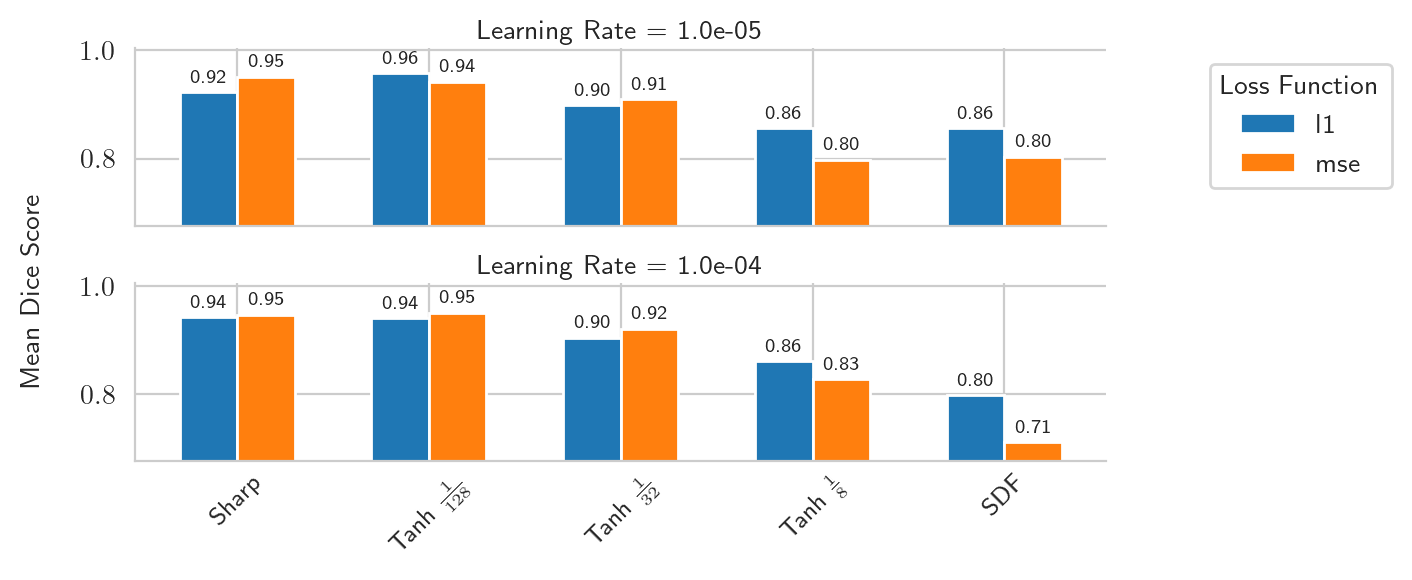

In [8]:
# ==============================================================================
# NEW PLOTTING CELL: Compare Loss Functions for a Fixed Hyperparameter Set (Pure Matplotlib, Stacked)
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# --- Define a reusable plotting function ---
def plot_loss_comparison_on_ax(ax, df, lr_value, fixed_weight_decay, fixed_act, universal_interface_order):
    """
    Filters data for a specific learning rate and plots the loss comparison
    bar chart on a given Matplotlib axes object.
    """
    # --- Filter the DataFrame for the specific LR ---
    df_filtered = df[
        (df['lr'] == lr_value) &
        (df['weight_decay'] == fixed_weight_decay) &
        (df['act_type'] == fixed_act)
    ].copy()

    # Get the two loss functions to compare from the main dataframe
    loss_types = sorted(df['loss'].unique())
    if len(loss_types) != 2:
        raise ValueError(f"Expected 2 loss types for comparison, but found {len(loss_types)}: {loss_types}")

    colors = ['C0', 'C1']
    bar_width = 0.30
    x_positions = np.arange(len(universal_interface_order))

    # --- Check for data and plot ---
    if df_filtered.empty:
        ax.text(0.5, 0.5, f'No data for lr={lr_value}', ha='center', va='center', transform=ax.transAxes, fontsize=10, alpha=0.7)
    else:
        for i, interface_name in enumerate(universal_interface_order):
            df_interface = df_filtered[df_filtered['full_interface_name'] == interface_name]

            # Plot left bar
            loss1_data = df_interface[df_interface['loss'] == loss_types[0]]
            score1 = loss1_data['mean_dice'].iloc[0] if not loss1_data.empty else 0
            pos1 = x_positions[i] - bar_width
            ax.bar(pos1, score1, width=bar_width, color=colors[0], align='edge')
            if score1 > 0:
                ax.annotate(f'{score1:.2f}', (pos1 + bar_width / 2, score1), ha='center', va='bottom', fontsize=7, xytext=(0, 2), textcoords='offset points')

            # Plot right bar
            loss2_data = df_interface[df_interface['loss'] == loss_types[1]]
            score2 = loss2_data['mean_dice'].iloc[0] if not loss2_data.empty else 0
            pos2 = x_positions[i]
            ax.bar(pos2, score2, width=bar_width, color=colors[1], align='edge')
            if score2 > 0:
                ax.annotate(f'{score2:.2f}', (pos2 + bar_width / 2, score2), ha='center', va='bottom', fontsize=7, xytext=(0, 2), textcoords='offset points')

    # --- Configure axes aesthetics ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', length=0)

    # --- Set a title for the individual subplot ---
    ax.set_title(f'Learning Rate = {lr_value:.1e}', loc='center', fontsize=10, pad=3)


# ==============================================================================
# --- Main Script to Generate the Stacked Plot ---
# ==============================================================================

print("=" * 80)
print("--- Generating stacked plot to compare loss functions across learning rates ---")
print("=" * 80)

# --- Define fixed parameters ---
FIXED_WEIGHT_DECAY = 1e-6
FIXED_ACT = 'silu'
INTERFACE_TO_MOVE_LAST = 'SDF_EXACT'

# --- Determine the universal order of interfaces across all relevant data ---
df_plot_data = df[
    (df['weight_decay'] == FIXED_WEIGHT_DECAY) &
    (df['act_type'] == FIXED_ACT) &
    (df['lr'].isin([1e-5, 1e-4]))
]

if df_plot_data.empty:
    print("\n!!! SKIPPING PLOT: No data found for the required hyperparameter combinations. !!!\n")
else:
    universal_interface_order = sorted(df_plot_data['full_interface_name'].unique())
    if INTERFACE_TO_MOVE_LAST in universal_interface_order:
        universal_interface_order.remove(INTERFACE_TO_MOVE_LAST)
        universal_interface_order.append(INTERFACE_TO_MOVE_LAST)

    # --- Create the figure and stacked subplots ---
    fig, axs = plt.subplots(2, 1, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

    # --- Call the plotting function for each subplot ---
    plot_loss_comparison_on_ax(axs[0], df, 1e-5, FIXED_WEIGHT_DECAY, FIXED_ACT, universal_interface_order)
    plot_loss_comparison_on_ax(axs[1], df, 1e-4, FIXED_WEIGHT_DECAY, FIXED_ACT, universal_interface_order)

    # --- Configure shared elements for the entire figure ---

    # Set x-ticks and labels only on the bottom plot
    plt.xticks(ticks=np.arange(len(universal_interface_order)),
               labels=['Sharp', 'Tanh $\\frac{1}{128}$', 'Tanh $\\frac{1}{32}$', 'Tanh $\\frac{1}{8}$', 'SDF'],
               rotation=45, ha='center', fontsize=9)

    # Set a single, centered y-label for the entire figure
    fig.supylabel('Mean Dice Score', fontsize=10)

    # Set Y-axis limits based on all data to be plotted
    min_score = df_plot_data['mean_dice'].min()
    max_score = df_plot_data['mean_dice'].max()
    axs[0].set_ylim(bottom=max(0, min_score * 0.95), top=max_score * 1.05)

    # Create a single legend for the figure
    loss_types = sorted(df['loss'].unique())
    colors = ['C0', 'C1']
    legend_elements = [Patch(facecolor=colors[i], label=loss) for i, loss in enumerate(loss_types)]
    fig.legend(handles=legend_elements, title='Loss Function', bbox_to_anchor=(1.0, 0.9), loc='upper left')

    # --- Final layout adjustment and display ---
    plt.tight_layout(rect=[0, 0, 0.95, 1])

    plt.savefig('output/hyperparam_loss_comparison.pdf', bbox_inches='tight')

    plt.show()

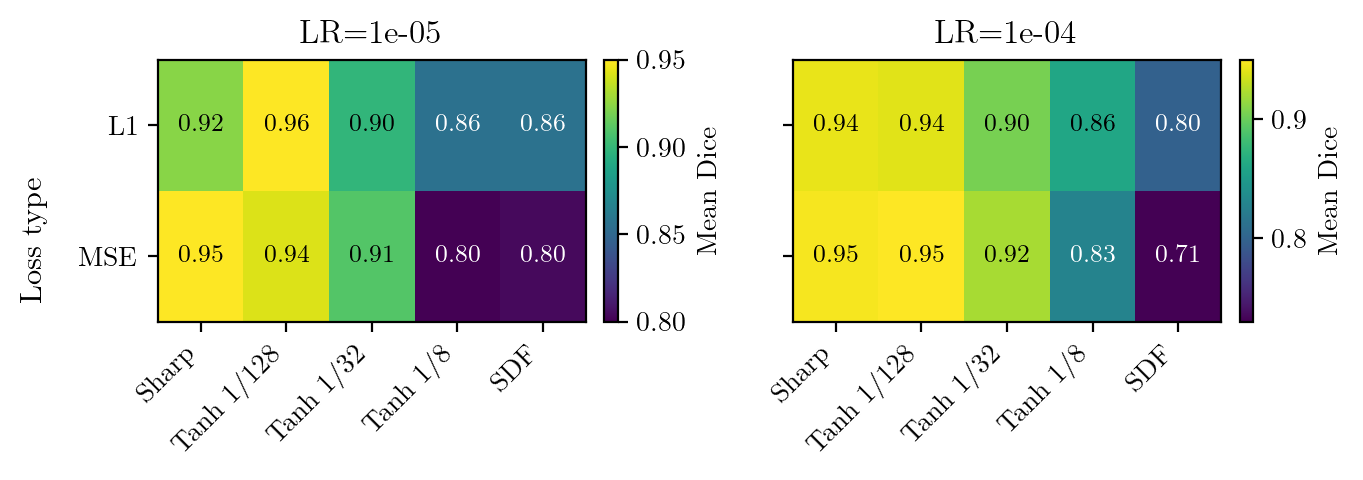

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rc_file_defaults()

def get_latex_interface_label(interface_name):
    """
    Map your full_interface_name to a nice display label.
    """
    lookup = {
        "HEAVISIDE": "Sharp",
        "TANH (1/128)": r'Tanh 1/128',
        "TANH (1/32)": r'Tanh 1/32',
        "TANH (1/8)": r'Tanh 1/8',
        "SDF_EXACT": "SDF"
    }
    return lookup.get(interface_name, interface_name)

def get_loss_label(loss_name):
    """
    Map your loss name to a display string (if needed)
    """
    lookup = {
        "mse": "MSE",
        "l1": "L1",
        "mae": "L1",
        "bce": "BCE"
    }
    return lookup.get(loss_name.lower(), loss_name)

def make_heatmap_table_for_lr(df, lr_value, metric, universal_interface_order, fixed_weight_decay, fixed_act):
    """
    Returns a 2D numpy array of shape (n_loss_types, n_interfaces):
    Each entry is the mean metric for that (loss, interface) at the specified LR.
    """
    df_filtered = df[
        (df['lr'] == lr_value) &
        (df['weight_decay'] == fixed_weight_decay) &
        (df['act_type'] == fixed_act)
    ].copy()
    loss_types = sorted(df_filtered['loss'].unique())
    data = np.full((len(loss_types), len(universal_interface_order)), np.nan)
    for i, loss in enumerate(loss_types):
        for j, interface_name in enumerate(universal_interface_order):
            val = df_filtered[
                (df_filtered['loss'] == loss) &
                (df_filtered['full_interface_name'] == interface_name)
            ][metric]
            if not val.empty:
                data[i, j] = val.iloc[0]
    return data, loss_types

def plot_heatmap_with_annotations(
    ax, data, row_labels, col_labels, vmin, vmax, fmt=".3f", cmap="viridis", title=""):
    im = ax.imshow(data, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    n_rows, n_cols = data.shape
    for i in range(n_rows):
        for j in range(n_cols):
            val = data[i, j]
            if not np.isnan(val):
                color = "white" if val < vmin + 0.5*(vmax-vmin) else "black"
                ax.text(j, i, format(val, fmt), va='center', ha='center', fontsize=9, color=color)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_title(title)
    ax.grid(False)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Mean Dice')
    # Hide spines (optional)
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)

# ------------------------------------
# Config
# ------------------------------------
FIXED_WEIGHT_DECAY = 1e-6
FIXED_ACT = 'silu'
INTERFACE_TO_MOVE_LAST = 'SDF_EXACT'
LEARNING_RATES = [1e-5, 1e-4]
METRIC = "mean_dice"       # Or change to mean_hausdorff if present

df_plot_data = df[
    (df['weight_decay'] == FIXED_WEIGHT_DECAY) &
    (df['act_type'] == FIXED_ACT) &
    (df['lr'].isin(LEARNING_RATES))
]

universal_interface_order = sorted(df_plot_data['full_interface_name'].unique())
if INTERFACE_TO_MOVE_LAST in universal_interface_order:
    universal_interface_order.remove(INTERFACE_TO_MOVE_LAST)
    universal_interface_order.append(INTERFACE_TO_MOVE_LAST)

column_labels = [get_latex_interface_label(x) for x in universal_interface_order]

# Assemble plot data for both LRs
data_lr1, loss_types = make_heatmap_table_for_lr(df, LEARNING_RATES[0], METRIC, universal_interface_order, FIXED_WEIGHT_DECAY, FIXED_ACT)
data_lr2, _         = make_heatmap_table_for_lr(df, LEARNING_RATES[1], METRIC, universal_interface_order, FIXED_WEIGHT_DECAY, FIXED_ACT)
row_labels = [get_loss_label(x) for x in loss_types]

# GLOBAL vmin/vmax for consistency
all_data = np.concatenate([data_lr1.flatten(), data_lr2.flatten()])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), dpi=200, sharey=True)
plot_heatmap_with_annotations(
    axs[0], data_lr1, row_labels, column_labels, 0.80, 0.95, fmt=".2f", cmap="viridis",
    title=f"LR={LEARNING_RATES[0]:.0e}"
)
plot_heatmap_with_annotations(
    axs[1], data_lr2, row_labels, column_labels, 0.73, 0.95, fmt=".2f", cmap="viridis",
    title=f"LR={LEARNING_RATES[1]:.0e}"
)
fig.supylabel("Loss type", fontsize=11)
plt.tight_layout()
plt.savefig('output/lossfunc_heatmaps.pdf', bbox_inches='tight')
plt.show()